In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        assert dim % num_heads == 0, "Dimension must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.fc_out = nn.Linear(dim, dim)
        self.scale = self.head_dim ** 0.5
    
    def forward(self, x):
        batch_size, seq_length, dim = x.shape
        Q = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        attn_output = attn_weights @ V
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, dim)
        
        return self.fc_out(attn_output)

# Transformer PINN Model
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)  # Regularization
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.attn(x.unsqueeze(1)).squeeze(1)
        x = self.dropout(x)
        return self.fc2(x)

# Load and Normalize FEA Data
def load_fea_data(csv_path):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    # Normalize using MinMaxScaler
    scaler = MinMaxScaler()
    df[required_columns] = scaler.fit_transform(df[required_columns])

    X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
    stress = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).unsqueeze(-1)

    return X, stress, scaler  # Return scaler for inverse transform

# Physics-Informed Loss Function
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    
    # Physics-based equilibrium equation
    equilibrium_loss = torch.mean((stress_grad[:, 0] + stress_grad[:, 1]) ** 2)

    # Boundary loss
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)

    # Plasticity loss
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_constraint = sigma_y + strain_hardening * (stress_pred - sigma_y)
    plasticity_loss = torch.mean(torch.relu(stress_pred - plasticity_constraint) ** 2)

    # Data-driven loss (MSE)
    fea_loss = torch.mean((stress_pred - stress_true) ** 2)

    # Weighted loss combination
    loss = (
        0.5 * equilibrium_loss +
        0.3 * boundary_loss +
        0.1 * plasticity_loss +
        1.0 * fea_loss  # Higher weight on FEA loss
    )
    
    return loss

# Training Function with Gradient Clipping
def train(model, optimizer, scheduler, csv_path, epochs=500):
    for epoch in range(epochs):
        X, stress_true, _ = load_fea_data(csv_path)  # Load and normalize data
        loss = physics_loss(model, X, stress_true)
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()  # Adjust learning rate

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Model Evaluation Function
def evaluate_model(model, test_csv):
    model.eval()  # Set model to evaluation mode
    X_test, stress_true, scaler = load_fea_data(test_csv)

    with torch.no_grad():
        stress_pred = model(X_test)


    # Only inverse transform the stress column
    stress_pred = stress_pred.numpy()
    stress_true = stress_true.numpy()

    stress_min = scaler.data_min_[-1]  # Min value of stress
    stress_max = scaler.data_max_[-1]  # Max value of stress

    stress_pred = stress_pred * (stress_max - stress_min) + stress_min
    stress_true = stress_true * (stress_max - stress_min) + stress_min


    # Compute Mean Absolute Error (MAE)
    mae = abs(stress_pred - stress_true).mean()
    print(f"Mean Absolute Error: {mae:.6f}")

    return stress_pred, stress_true

# Prediction Function
def predict(model, input_data):
    model.eval()
    input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        predicted_stress = model(input_tensor)

    return predicted_stress.item()

# Initialize and Train the Model
csv_path = 'fea_data.csv'  # Replace with actual file path
test_csv = 'fea_data.csv'  # Test data file
model = TransformerPINN()

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler (reduce by 50% every 100 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Train the Model
train(model, optimizer, scheduler, csv_path)

# Evaluate Model on Test Data
evaluate_model(model, test_csv)

# Example Prediction
sample_input = [0.5, 0.5, 2e9, 0.3, 0.01, 250e6, 100e6]  # Example input values
predicted_stress = predict(model, sample_input)
print(f"Predicted Stress: {predicted_stress:.6f} MPa")


## 2. With Plot

In [ ]:
!pip install torch pandas numpy matplotlib scikit-learn



Epoch 0, Loss: 12084.7724609375
Epoch 50, Loss: 509.17041015625
Epoch 100, Loss: 28.517847061157227
Epoch 150, Loss: 9.766812324523926
Epoch 200, Loss: 6.080425262451172
Epoch 250, Loss: 7.043294429779053
Epoch 300, Loss: 4.884357452392578
Epoch 350, Loss: 3.1189568042755127
Epoch 400, Loss: 1.84550940990448
Epoch 450, Loss: 1.864227533340454
MAE: 36043016.0, MSE: 2086781801463808.0


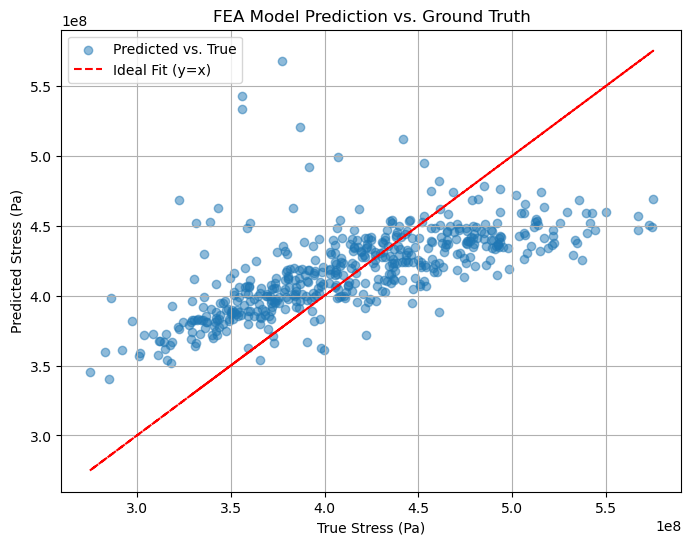

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize Global Scaler
scaler = MinMaxScaler()

# ✅ Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(dim, dim * num_heads)
        self.key = nn.Linear(dim, dim * num_heads)
        self.value = nn.Linear(dim, dim * num_heads)
        self.proj = nn.Linear(dim * num_heads, dim)
        self.scale = (dim ** 0.5)

    def forward(self, x):
        B, N, D = x.shape  # (Batch, Nodes, Features)
        Q = self.query(x).view(B, N, self.num_heads, D).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, D).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, D).transpose(1, 2)

        attn_weights = torch.softmax((Q @ K.transpose(-2, -1)) / self.scale, dim=-1)
        attn_output = (attn_weights @ V).transpose(1, 2).contiguous().view(B, N, D * self.num_heads)

        return self.proj(attn_output)

# ✅ Transformer PINN Model
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x.unsqueeze(0)).squeeze(0)  # Add batch dim for attention
        return self.fc2(x)

# ✅ Load & Normalize FEA Data
def load_fea_data(csv_path, fit_scaler=False):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    X = df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values
    stress = df['stress'].values.reshape(-1, 1)

    if fit_scaler:
        scaler.fit(np.hstack([X, stress]))  # Fit on features & stress

    normalized_data = scaler.transform(np.hstack([X, stress]))
    X_normalized = normalized_data[:, :-1]
    stress_normalized = normalized_data[:, -1].reshape(-1, 1)

    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(stress_normalized, dtype=torch.float32)

# ✅ Physics-Informed Loss Function
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Stress equilibrium condition

    # Dirichlet Boundary (stress = 0 at edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)

    # Neumann Boundary Conditions
    force_positions = [(0.9, 0.5), (0.5, 0.9)]
    neumann_loss = 0
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)

    # Plasticity with Strain Hardening
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - (sigma_y + strain_hardening * (stress_pred - sigma_y))) ** 2)

    # Mean Squared Error with FEA data
    fea_loss = torch.mean((stress_pred - stress_true) ** 2)

    return torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss + fea_loss

# ✅ Training Loop
def train(model, optimizer, scheduler, csv_path, epochs=500):
    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)  # Load Data
        loss = physics_loss(model, X, stress_true)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# ✅ Evaluation & Plotting
def evaluate_model(model, test_csv):
    X_test, stress_true = load_fea_data(test_csv)
    model.eval()
    with torch.no_grad():
        stress_pred = model(X_test).numpy()
    
    stress_true = stress_true.numpy()

    # Inverse Transform Stress
    stress_min = scaler.data_min_[-1]
    stress_max = scaler.data_max_[-1]
    stress_pred = stress_pred * (stress_max - stress_min) + stress_min
    stress_true = stress_true * (stress_max - stress_min) + stress_min

    # Compute Errors
    mae = np.mean(np.abs(stress_pred - stress_true))
    mse = np.mean((stress_pred - stress_true) ** 2)

    print(f"MAE: {mae}, MSE: {mse}")

    # Plot Predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(stress_true, stress_pred, alpha=0.5, label="Predicted vs. True")
    plt.plot(stress_true, stress_true, 'r--', label="Ideal Fit (y=x)")
    plt.xlabel("True Stress (Pa)")
    plt.ylabel("Predicted Stress (Pa)")
    plt.title("FEA Model Prediction vs. Ground Truth")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Initialize & Train Model
csv_path = 'fea_data.csv'  # Replace with actual file
test_csv = 'fea_data.csv'  # Replace with actual test file

model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

# Train & Evaluate
X_train, stress_train = load_fea_data(csv_path, fit_scaler=True)  # Fit scaler
train(model, optimizer, scheduler, csv_path)
evaluate_model(model, test_csv)


# 3. With Logging


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import MinMaxScaler

# ✅ Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Initialize Scaler
scaler = MinMaxScaler()

# ✅ Multi-Head Self-Attention with Logging
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(dim, dim * num_heads)
        self.key = nn.Linear(dim, dim * num_heads)
        self.value = nn.Linear(dim, dim * num_heads)
        self.proj = nn.Linear(dim * num_heads, dim)
        self.scale = (dim ** 0.5)

    def forward(self, x):
        B, N, D = x.shape  # (Batch, Nodes, Features)
        logging.info(f"Self-Attention Input Shape: {x.shape}")

        Q = self.query(x).view(B, N, self.num_heads, D).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, D).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, D).transpose(1, 2)

        attn_weights = torch.softmax((Q @ K.transpose(-2, -1)) / self.scale, dim=-1)
        attn_output = (attn_weights @ V).transpose(1, 2).contiguous().view(B, N, D * self.num_heads)

        logging.info(f"Attention Weights: {attn_weights.mean().item()} (Avg)")

        return self.proj(attn_output)

# ✅ Transformer PINN Model with Logging
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        logging.info(f"Model Input Shape: {x.shape}")

        x = torch.relu(self.fc1(x))
        logging.info(f"FC1 Output Shape: {x.shape}")

        x = self.attn(x.unsqueeze(0)).squeeze(0)  # Add batch dim for attention
        logging.info(f"Attention Output Shape: {x.shape}")

        output = self.fc2(x)
        logging.info(f"Final Output Shape: {output.shape}")
        return output

# ✅ Load & Normalize FEA Data
def load_fea_data(csv_path, fit_scaler=False):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    X = df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values
    stress = df['stress'].values.reshape(-1, 1)

    if fit_scaler:
        scaler.fit(np.hstack([X, stress]))  # Fit on features & stress

    normalized_data = scaler.transform(np.hstack([X, stress]))
    X_normalized = normalized_data[:, :-1]
    stress_normalized = normalized_data[:, -1].reshape(-1, 1)

    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(stress_normalized, dtype=torch.float32)

# ✅ Physics-Informed Loss Function
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Stress equilibrium condition

    # Log gradients
    logging.info(f"Stress Gradient Mean: {stress_grad.mean().item()}")

    # Dirichlet Boundary (stress = 0 at edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)

    # Neumann Boundary Conditions
    force_positions = [(0.9, 0.5), (0.5, 0.9)]
    neumann_loss = 0
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)

    # Plasticity with Strain Hardening
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - (sigma_y + strain_hardening * (stress_pred - sigma_y))) ** 2)

    # Mean Squared Error with FEA data
    fea_loss = torch.mean((stress_pred - stress_true) ** 2)

    total_loss = torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss + fea_loss
    logging.info(f"Total Loss: {total_loss.item()}")
    return total_loss

# ✅ Training Loop
def train(model, optimizer, scheduler, csv_path, epochs=500):
    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)  # Load Data
        loss = physics_loss(model, X, stress_true)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()

        if epoch % 50 == 0:
            logging.info(f"Epoch {epoch}, Loss: {loss.item()}")

# ✅ Initialize & Train Model
csv_path = 'fea_data.csv'  # Replace with actual file
test_csv = 'fea_test_data.csv'  # Replace with actual test file

model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

# Train & Evaluate
X_train, stress_train = load_fea_data(csv_path, fit_scaler=True)  # Fit scaler
train(model, optimizer, scheduler, csv_path)


2025-02-15 18:41:18,666 - INFO - Model Input Shape: torch.Size([500, 7])
2025-02-15 18:41:18,666 - INFO - FC1 Output Shape: torch.Size([500, 128])
2025-02-15 18:41:18,667 - INFO - Self-Attention Input Shape: torch.Size([1, 500, 128])
2025-02-15 18:41:18,670 - INFO - Attention Weights: 0.0020000000949949026 (Avg)
2025-02-15 18:41:18,671 - INFO - Attention Output Shape: torch.Size([500, 128])
2025-02-15 18:41:18,671 - INFO - Final Output Shape: torch.Size([500, 1])
2025-02-15 18:41:18,675 - INFO - Stress Gradient Mean: -0.009474554099142551
2025-02-15 18:41:18,676 - INFO - Total Loss: 12081.6083984375
2025-02-15 18:41:18,691 - INFO - Epoch 0, Loss: 12081.6083984375
2025-02-15 18:41:18,693 - INFO - Model Input Shape: torch.Size([500, 7])
2025-02-15 18:41:18,693 - INFO - FC1 Output Shape: torch.Size([500, 128])
2025-02-15 18:41:18,693 - INFO - Self-Attention Input Shape: torch.Size([1, 500, 128])
2025-02-15 18:41:18,696 - INFO - Attention Weights: 0.0020000000949949026 (Avg)
2025-02-15 18:

KeyboardInterrupt: 

# 4.Run Time Plot


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import MinMaxScaler

# ✅ Enable Interactive Mode
plt.ion()

# ✅ Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

scaler = MinMaxScaler()

# ✅ Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(dim, dim * num_heads)
        self.key = nn.Linear(dim, dim * num_heads)
        self.value = nn.Linear(dim, dim * num_heads)
        self.proj = nn.Linear(dim * num_heads, dim)
        self.scale = dim ** 0.5

    def forward(self, x):
        B, N, D = x.shape
        Q = self.query(x).view(B, N, self.num_heads, D).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, D).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, D).transpose(1, 2)
        attn_weights = torch.softmax((Q @ K.transpose(-2, -1)) / self.scale, dim=-1)
        attn_output = (attn_weights @ V).transpose(1, 2).contiguous().view(B, N, D * self.num_heads)
        return self.proj(attn_output)

# ✅ Transformer PINN Model
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x.unsqueeze(0)).squeeze(0)
        return self.fc2(x)

# ✅ Load & Normalize Data
def load_fea_data(csv_path, fit_scaler=False):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    X = df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values
    stress = df['stress'].values.reshape(-1, 1)

    if fit_scaler:
        scaler.fit(np.hstack([X, stress]))

    normalized_data = scaler.transform(np.hstack([X, stress]))
    X_normalized = normalized_data[:, :-1]
    stress_normalized = normalized_data[:, -1].reshape(-1, 1)

    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(stress_normalized, dtype=torch.float32)

# ✅ Physics-Informed Loss
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  

    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)

    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - (sigma_y + strain_hardening * (stress_pred - sigma_y))) ** 2)

    fea_loss = torch.mean((stress_pred - stress_true) ** 2)
    return torch.mean(equilibrium**2) + boundary_loss + plasticity_loss + fea_loss

# ✅ Training Loop with Enhanced Visualization
def train(model, optimizer, scheduler, csv_path, epochs=500):
    loss_history = []
    gradient_norms = []
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ✅ Initialize Plots
    axes[0].set_title("Training Loss Curve")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].set_title("Gradient Magnitude")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Gradient Norm")

    axes[2].set_title("Predicted vs. Ground Truth Stress")
    axes[2].set_xlabel("Ground Truth Stress")
    axes[2].set_ylabel("Predicted Stress")

    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)
        loss = physics_loss(model, X, stress_true)

        optimizer.zero_grad()
        loss.backward()

        # ✅ Track Gradient Norm
        total_norm = 0
        for param in model.parameters():
            param_norm = param.grad.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # ✅ Live Plot Updates
        axes[0].clear()
        axes[0].plot(loss_history, label="Loss", color="blue")
        axes[0].legend()

        axes[1].clear()
        axes[1].plot(gradient_norms, label="Gradient Norm", color="red")
        axes[1].legend()

        # ✅ Predicted vs. Ground Truth Plot (Sample)
        if epoch % 10 == 0:
            # Fix inverse transform by adding dummy columns before transforming
            with torch.no_grad():
                stress_pred = model(X).numpy()

                # Create a dummy feature set (7 features + stress)
                dummy_X = np.zeros((stress_pred.shape[0], 7))  
                full_pred = np.hstack([dummy_X, stress_pred])  # Add stress column to dummy features

                # Apply inverse transform and extract only stress values
                stress_pred = scaler.inverse_transform(full_pred)[:, -1]  
                stress_true_orig = scaler.inverse_transform(np.hstack([dummy_X, stress_true.numpy()]))[:, -1]

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.01)

        if epoch % 50 == 0:
            logging.info(f"Epoch {epoch}, Loss: {loss.item()}, Gradient Norm: {total_norm}")

    plt.ioff()
    plt.show()

# ✅ Initialize & Train Model
csv_path = 'fea_data.csv'  
model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

X_train, stress_train = load_fea_data(csv_path, fit_scaler=True)  
train(model, optimizer, scheduler, csv_path)


In [19]:
%matplotlib inline


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import MinMaxScaler

# ✅ Enable Interactive Mode

# ✅ Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

scaler = MinMaxScaler()

# ✅ Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.query = nn.Linear(dim, dim * num_heads)
        self.key = nn.Linear(dim, dim * num_heads)
        self.value = nn.Linear(dim, dim * num_heads)
        self.proj = nn.Linear(dim * num_heads, dim)
        self.scale = dim ** 0.5

    def forward(self, x):
        B, N, D = x.shape
        Q = self.query(x).view(B, N, self.num_heads, D).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, D).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, D).transpose(1, 2)
        attn_weights = torch.softmax((Q @ K.transpose(-2, -1)) / self.scale, dim=-1)
        attn_output = (attn_weights @ V).transpose(1, 2).contiguous().view(B, N, D * self.num_heads)
        return self.proj(attn_output)

# ✅ Transformer PINN Model
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x.unsqueeze(0)).squeeze(0)
        return self.fc2(x)

# ✅ Load & Normalize Data
def load_fea_data(csv_path, fit_scaler=False):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    X = df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values
    stress = df['stress'].values.reshape(-1, 1)

    if fit_scaler:
        scaler.fit(np.hstack([X, stress]))

    normalized_data = scaler.transform(np.hstack([X, stress]))
    X_normalized = normalized_data[:, :-1]
    stress_normalized = normalized_data[:, -1].reshape(-1, 1)

    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(stress_normalized, dtype=torch.float32)

# ✅ Physics-Informed Loss
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  

    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)

    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - (sigma_y + strain_hardening * (stress_pred - sigma_y))) ** 2)

    fea_loss = torch.mean((stress_pred - stress_true) ** 2)
    return torch.mean(equilibrium**2) + boundary_loss + plasticity_loss + fea_loss

# ✅ Training Loop with Live Visualization
def train(model, optimizer, scheduler, csv_path, epochs=500):
    loss_history = []
    gradient_norms = []

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.ion()  # Turn on interactive mode

    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)
        loss = physics_loss(model, X, stress_true)

        optimizer.zero_grad()
        loss.backward()

        # ✅ Track Gradient Norm
        total_norm = 0
        for param in model.parameters():
            param_norm = param.grad.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # ✅ Update Plots Live
        axes[0].clear()
        axes[0].plot(loss_history, label="Loss", color="blue")
        axes[0].set_title("Training Loss Curve")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        axes[1].clear()
        axes[1].plot(gradient_norms, label="Gradient Norm", color="red")
        axes[1].set_title("Gradient Magnitude")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Gradient Norm")
        axes[1].legend()

        # ✅ Predicted vs. Ground Truth Plot (Sample Every 10 Epochs)
        if epoch % 10 == 0:
            with torch.no_grad():
                stress_pred = model(X).numpy()
                dummy_X = np.zeros((stress_pred.shape[0], 7))  
                full_pred = np.hstack([dummy_X, stress_pred])  
                stress_pred = scaler.inverse_transform(full_pred)[:, -1]  
                stress_true_orig = scaler.inverse_transform(np.hstack([dummy_X, stress_true.numpy()]))[:, -1]

                axes[2].clear()
                axes[2].scatter(stress_true_orig, stress_pred, alpha=0.5, label="Predicted vs True")
                axes[2].plot(stress_true_orig, stress_true_orig, 'r--', label="Ideal Line")
                axes[2].set_title("Predicted vs True Stress")
                axes[2].set_xlabel("True Stress")
                axes[2].set_ylabel("Predicted Stress")
                axes[2].legend()

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.01)

        if epoch % 50 == 0:
            logging.info(f"Epoch {epoch}, Loss: {loss.item()}, Gradient Norm: {total_norm}")

    plt.ioff()
    plt.show()

# ✅ Initialize & Train Model
csv_path = 'fea_data.csv'  
model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

X_train, stress_train = load_fea_data(csv_path, fit_scaler=True)  
train(model, optimizer, scheduler, csv_path)
